# Прогнозирование уровня средней заработной платы в России

## Часть 1

Известны данные о среднемесячных уровнях заработной платы в России за каждый месяц с января 1993 по август 2016. 

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

__Алгоритм построения прогноза:__

1) Визуальный анализ ряда

2) Стабилизация дисперсии (при необходимости)

3) Выбор порядка дифференцирования

4) Выбор начальных приближений для $p$, $q$, $P$, $Q$

5) Обучение и сравнение моделей-кандидатов, выбор победителя

6) Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p$, $q$, $P$, $Q$.

7) Прогнозирование с помощью финальной модели.

### 0. Предобработка данных

In [1]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

from matplotlib import pyplot
import matplotlib.ticker as ticker

from scipy import stats
import statsmodels.api as sm

from itertools import product

import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta

import warnings

Загрузка данных

In [2]:
old_data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
old_data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Загрузим обновленные данные с сайта [Единого архива экономических и социологических данных НИУ ВШЭ](http://sophist.hse.ru/)

In [4]:
import requests # Модуль для обработки URL
from bs4 import BeautifulSoup # Модуль для работы с HTML

url = 'http://sophist.hse.ru/hse/1/tables/WAG_M.htm'

# Заголовки для передачи вместе с URL
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.129 Safari/537.36'}

# Парсим всю страницу
full_page = requests.get(url, headers)

# Разбираем через BeautifulSoup
soup = BeautifulSoup(full_page.content, 'html.parser')

# Получаем нужную таблицу данных
rows = soup.findAll("tr")

years = []
months = []

# Реальная зарплата (WAG_M)
WAG_M = []

# Реальная зарплата с поправкой на сезонность (WAG_M_SA)
WAG_M_SA = []

# Средняя номинальная заработная плата (WAG_C_M)
WAG_C_M = []

year = 0
for row in rows[2:-4]:
    columns = row.find_all("td")
    columns[0].text
    
    # Метод .strip() удаляет пробельные символы в начале и в конце строки
    # Метод .split(' ') разбивает строку по разделителю ' '
    data_list = columns[0].text.strip().split(' ')
    
    if len(data_list) >= 2:
        year = int(data_list[0])
        month = int(data_list[1])
    else:
        month = int(data_list[0])
    
    years.append(year)
    months.append(month)
    
    # Метод .replace(',', '.') заменяет первый символ на второй
    WAG_M.append(float(columns[1].text.strip().replace(',', '.')))
    WAG_M_SA.append(float(columns[2].text.strip().replace(',', '.')))
    WAG_C_M.append(float(columns[3].text.strip().replace(',', '.')))
    

new_data = pd.DataFrame({'month':list(map(lambda m, y: f'01.{str(m):>02}.{str(y):>04}', months, years)),
                     'WAG_M':WAG_M,
                     'WAG_M_SA':WAG_M_SA,
                     'WAG_C_M':WAG_C_M})

new_data.index = pd.to_datetime(new_data['month'], dayfirst=True)
new_data.drop(['month'], axis='columns', inplace=True)

del url, headers, full_page, soup, rows, row, years, year, months, month, WAG_M, WAG_M_SA, WAG_C_M, data_list, columns

In [5]:
new_data.head()

,WAG_M,WAG_M_SA,WAG_C_M
month,,,
1993-01-01,100.00,108.6,15.3
1993-02-01,99.04,111.5,19.1
1993-03-01,101.77,114.2,23.6
1993-04-01,110.05,116.4,30.6
1993-05-01,115.47,117.1,37.5


In [6]:
# Проверка наличия пропущенных значений в датасете
new_data.isnull().values.any()

False

Сравним данные Coursera с данными с сайта Единого архива экономических и социологических данных НИУ ВШЭ.

Для этого посмотрим на разность доступных участков рядов.

In [7]:
length = old_data.shape[0]

for index, old,  new in zip(old_data[:length].index, old_data['WAG_C_M'][:length], new_data['WAG_C_M'][:length]):
    if (old - new) != 0:
        print(index, (old - new))

2016-08-01 00:00:00 -1310.0


Значения рядов в августе 2016 различаются.

В качестве основного датасета будем использовать данные Coursera

In [8]:
data = old_data[['WAG_C_M']]

### 1. Визуальный анализ ряда

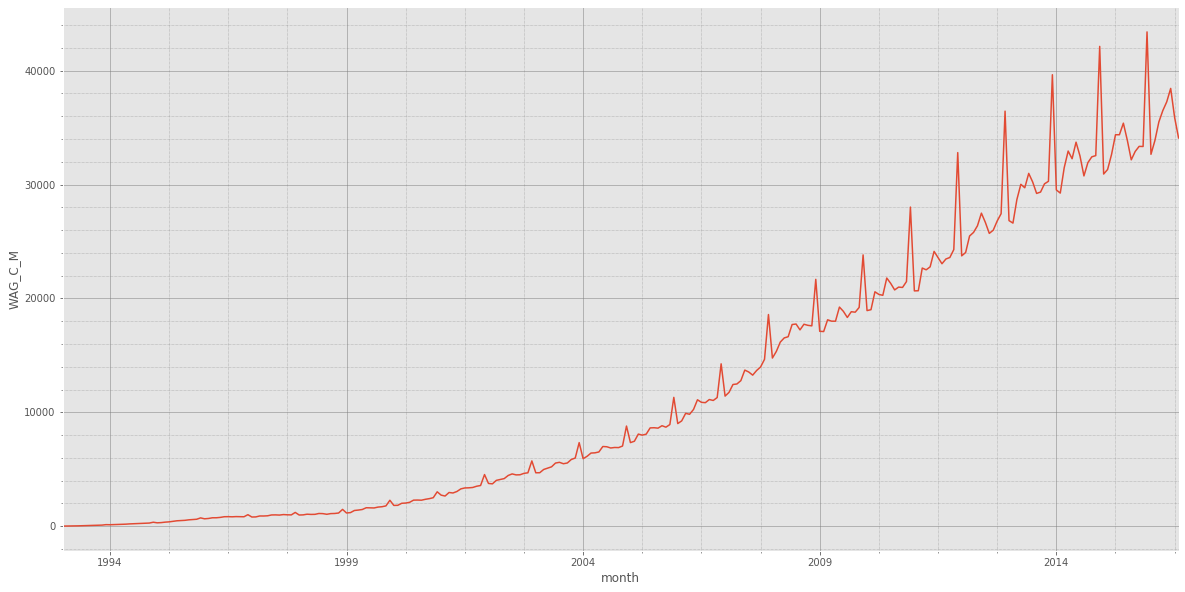

In [9]:
# Прогнозируемый ряд
fig, ax = pyplot.subplots(figsize=(20,10))
data['WAG_C_M'].plot()
pyplot.ylabel('WAG_C_M')
ax.minorticks_on()
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2000))
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

По графику видно, что ряд обладает слежующими свойствами:
- сильная годовая сезонность: плавный рост зароботной платы в течение года (с января по ноябрь) с резким ростом в декабре и последующим резким падением в январе
- присутствует ярко-выраженный нелинейный тренд (рост заработных плат)
- нестационарна дисперсия (размах сезонных колебаний увеличивается от начала к концу графика).

Проверка стационарности и STL-декомпозиция ряда:

In [15]:
def plotseasonal(res, ax, grid=False):
    """Возвращает STL-декомпозицию"""   
    # Исходный ряд
    res.observed.plot(ax=ax[0], legend=False)
    # Тренд
    res.trend.plot(ax=ax[1], legend=False)
    # Сезонность
    res.seasonal.plot(ax=ax[2], legend=False)
    # Остатки
    res.resid.plot(ax=ax[3], legend=False)
    
    label = ['Observed', 'Trend', 'Seasonal', 'Residual']
    for i in range(0,4):
        ax[i].set_ylabel(label[i])
    
    if grid == True:
        for i in range(0,4):
            ax[i].grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
            ax[i].grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')

Критерий Дики-Фуллера: p=0.991850


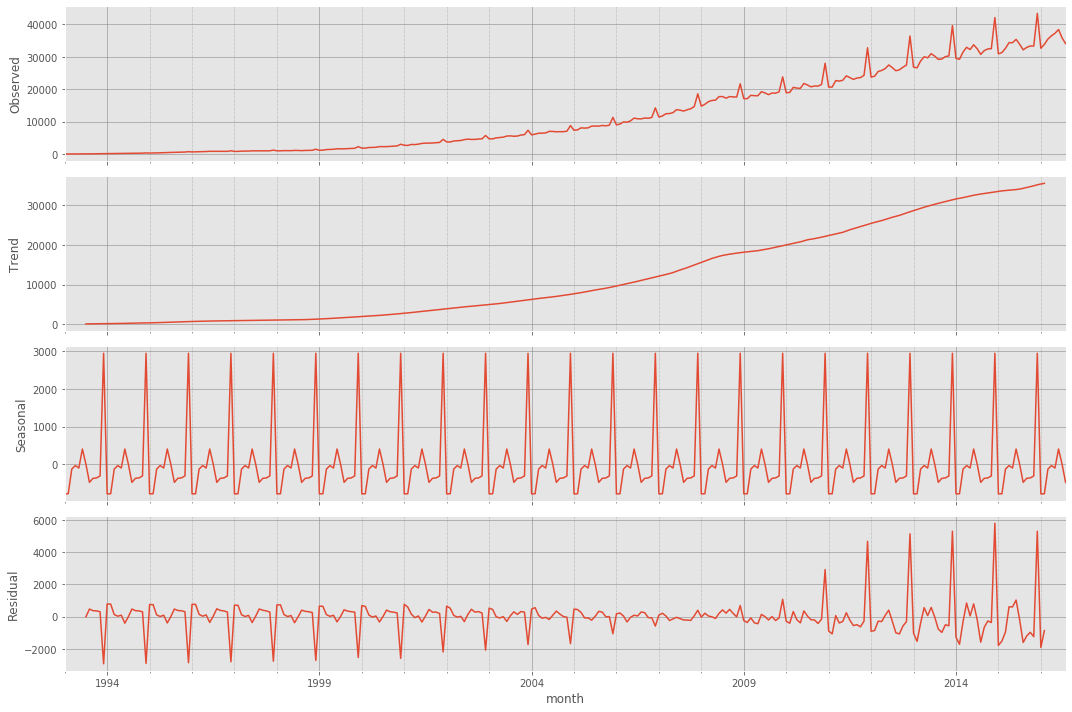

In [16]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M'])[1])

fig, ax = pyplot.subplots(4, 1, figsize=(15,10), sharex=True)
res = sm.tsa.seasonal_decompose(data['WAG_C_M'])
plotseasonal(res, ax, grid=True)
pyplot.tight_layout()
pyplot.show()

Достигаемый уровень значимости критерия Дики-Фуллера > 0.05, т.е. нулевая гипотеза нестационарности для данного ряда не отвергается. __Ряд не стационарен__

По графикам STL-декомпозиции видно:
- сезонный профиль хорошо выражен;
- тренд имеет нелинейную структуру;
- остатки  плавно растут с отрицательных до положительных значений

### 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


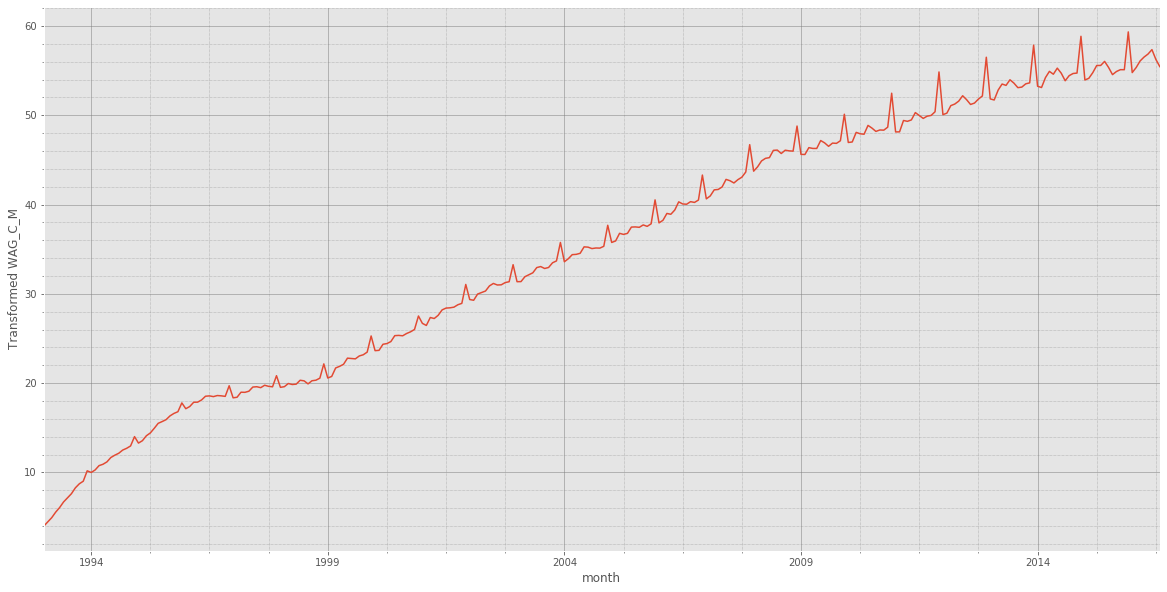

In [17]:
# Функция stats.boxcox возвращает преобразованный ряд и 
# подобранное оптимальное значение lambda

data['WAG_C_M_box'], lmbda = stats.boxcox(data['WAG_C_M'])

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M_box'])[1])

fig, ax = pyplot.subplots(figsize=(20,10))
data['WAG_C_M_box'].plot()
pyplot.ylabel(u'Transformed WAG_C_M')
ax.minorticks_on()
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

Достигаемый уровень значимости критерия Дики-Фуллера > 0.05, т.е. нулевая гипотеза нестационарности для данного ряда не отвергается. __Ряд не стационарен__

В данных по-прежнему:
- сильно выражена сезонность;
- присутствует тренд.

### 3. Выбор порядка дифференцирования

Применим сезонное дифференцирование. Сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность.

Критерий Дики-Фуллера: p=0.014697


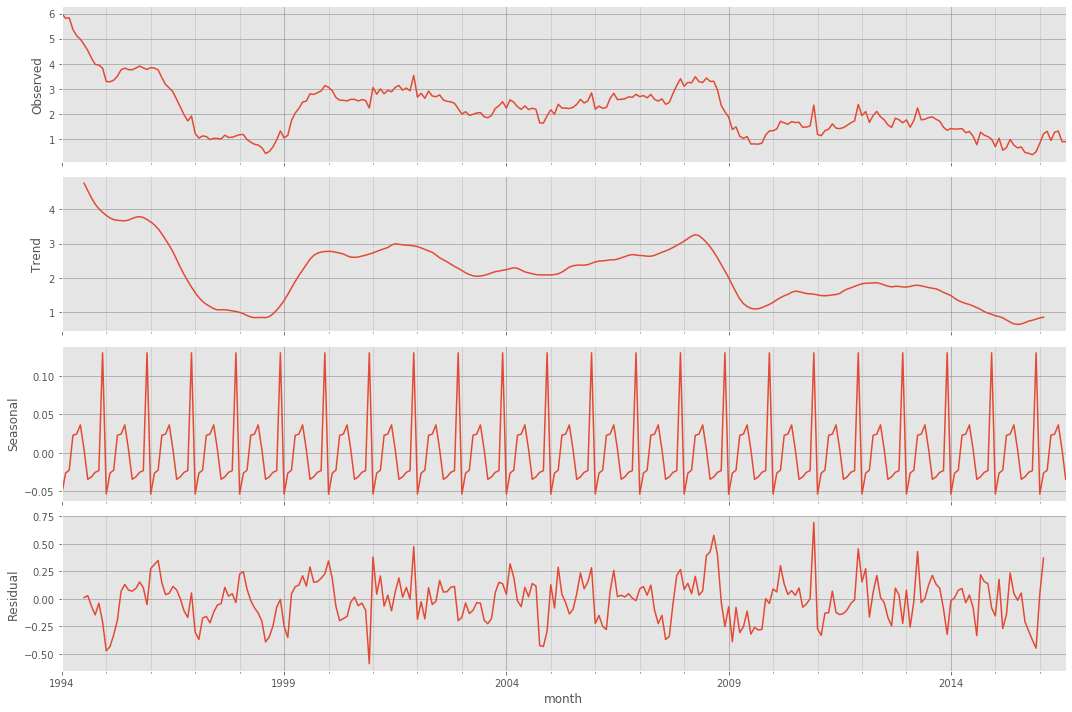

In [18]:
data['WAG_C_M_box_diff'] = data['WAG_C_M_box'] - data['WAG_C_M_box'].shift(12)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M_box_diff'][12:])[1])

fig, ax = pyplot.subplots(4, 1, figsize=(15,10), sharex=True)
res = sm.tsa.seasonal_decompose(data['WAG_C_M_box_diff'][12:])
plotseasonal(res, ax, grid=True)
pyplot.tight_layout()
pyplot.show()

Достигаемый уровень значимости критерия Дики-Фуллера < 0.05, т.е. нулевая гипотеза нестационарности для данного ряда отвергается. __Ряд стационарен__

Визуально четкого тренда больше нет.

### 4. Выбор начальных приближений для $p$, $q$, $P$, $Q$

Построим корреляционную функцию ACF и частично корреляционную функцию PACF полученного ряда

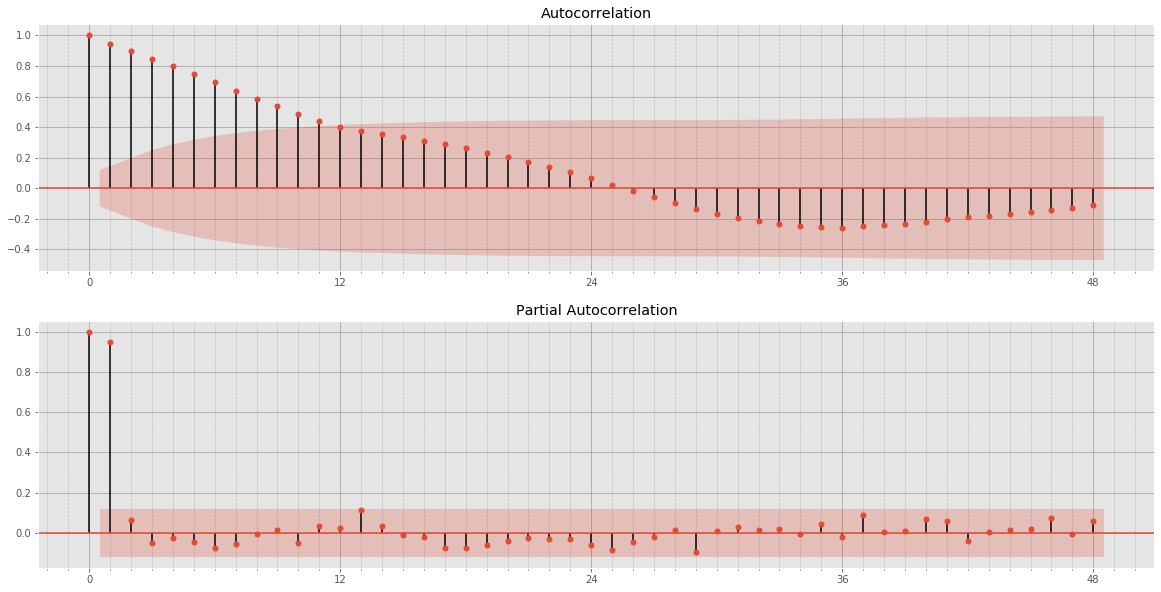

In [19]:
fig, ax = pyplot.subplots(2, 1, figsize=(20,10))

ax = pyplot.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(data['WAG_C_M_box_diff'][12:].values.squeeze(), lags=48, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle = ':')

ax = pyplot.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(data['WAG_C_M_box_diff'][12:].values.squeeze(), lags=48, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle = ':')

pyplot.show()

Из графика автокорреляции: 
- Сезонные лаги отсутствуют, следовательно начальное приближение $Q=1$. 
- Максимальный несезонный лаг в первом сезоне равен 11, следовательно начальное приближение $q=11$.

Из графика частичной автокорреляции:
- Сезонные лаги отсутствуют, следовательно начальное приближение $P=0$.
- Максимальный несезонный лаг в первом сезоне равен 1, следовательно начальное приближение $p=1$.

### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

Перебором подберем оптимальные параметры модели ARIMA. Перебор осуществляется по всем значениям от нуля до максимального, равного начальному приближению.

In [21]:
ps = range(0, 2)
d=0
qs = range(0, 12)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [22]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

96

Всего необходимо перебрать 96 моделей.

Для каждой модели посчитаем значение информационного критерия Акаике.

Выберем модель с минимальным значением этого критерия.

In [23]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['WAG_C_M_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        # Выводит модели, на которых сходимости не произошло
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 4min 15s


In [24]:
# Лучшие модели
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
87   (1, 9, 1, 1) -9.143559
86   (1, 9, 1, 0) -8.206190
85   (1, 9, 0, 1) -7.905899
84   (1, 9, 0, 0) -7.882552
91  (1, 10, 1, 1) -7.490053


### 6. Анализ остатков построенной модели, её модификация

In [25]:
# Лучшая модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 0, 9)x(1, 1, 1, 12)   Log Likelihood                  17.572
Date:                            Mon, 13 Jul 2020   AIC                             -9.144
Time:                                    13:59:08   BIC                             37.732
Sample:                                01-01-1993   HQIC                             9.675
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9819      0.009    107.486      0.000       0.964       1.000
ma.L1         -0.1779      0.050   

Достигаемый уровень значимости критерия Льюнг — Бокса при некотором автоматически выбранном $Q$ > 0.05.

То есть, по всей видимости, остатки модели не автокоррелированы.

Критерий Стьюдента: p=0.517339
Критерий Дики-Фуллера: p=0.000000


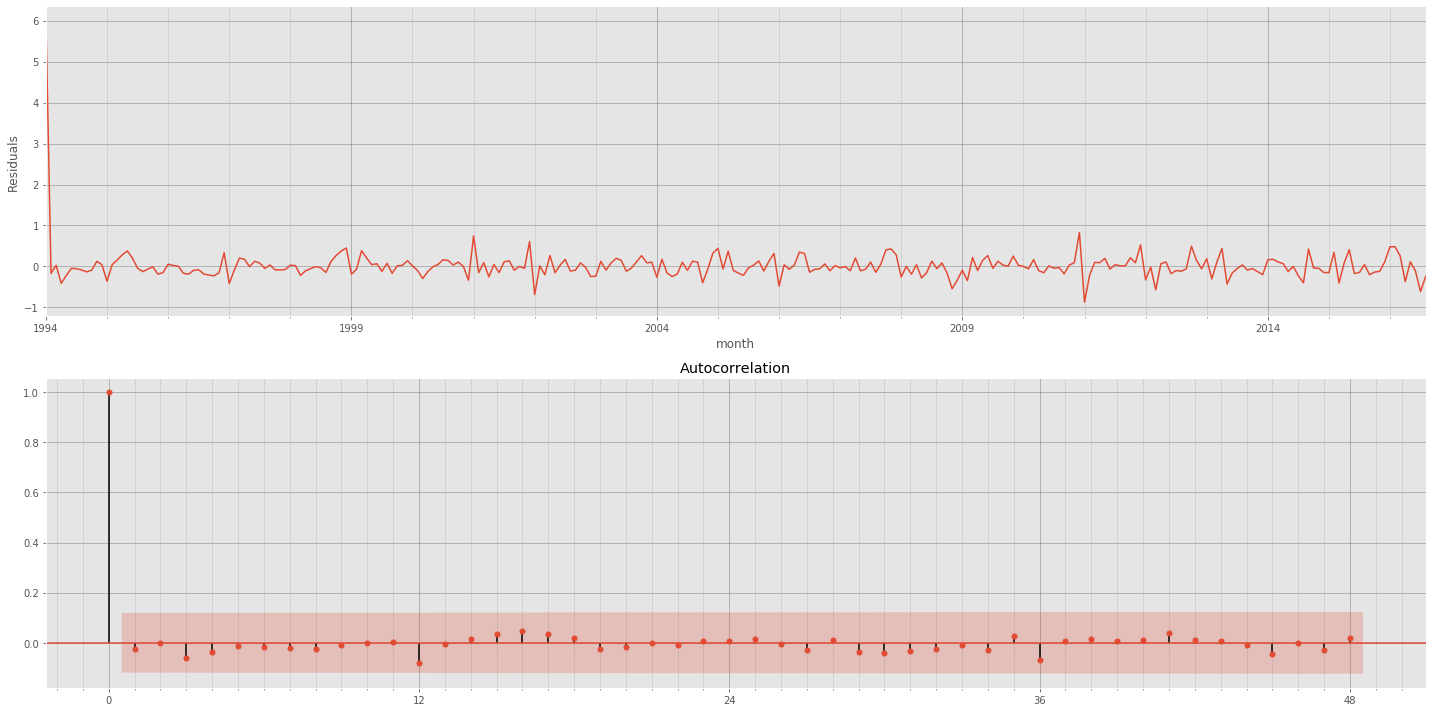

In [26]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

fig, ax = pyplot.subplots(2, 1, figsize=(20,10))

ax = pyplot.subplot(2, 1, 1)
best_model.resid[12:].plot()
pyplot.ylabel(u'Residuals')
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')

ax = pyplot.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=48, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle = ':')

pyplot.tight_layout()
pyplot.show()

В остатках не видно никакого тренда, никакой сезонности, они похожи на шум. 

На графике автокорреляционной функции этих остатков нет существенной структуры.

Проверим свойства остатков с помощью формальных критериев. 
- __Критерий Стьюдента__ проверяет __гипотезу несмещённости__ и её не отвергает с достигаемым уровнем значимости примерно 0,52. __Остатки несмещены__.
- __Критерий Дики-Фуллера__ уверенно отвергает __гипотезу нестационарности__. __Остатки стационарны__.
- __Критерий Льюнга-Бокса__ и __коррелограмма__ отвергают гипотезу автокоррелированности. __Остатки неавтокоррелированы__.

__Следовательно, модель достаточно хороша__.

### 7. Прогнозирование с помощью финальной модели

Посмотрим, насколько хорошо модель описывает данные

In [27]:
def invboxcox(y,lmbda):
    """Возвращает обратное преобразование Бокса-Кокса"""
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

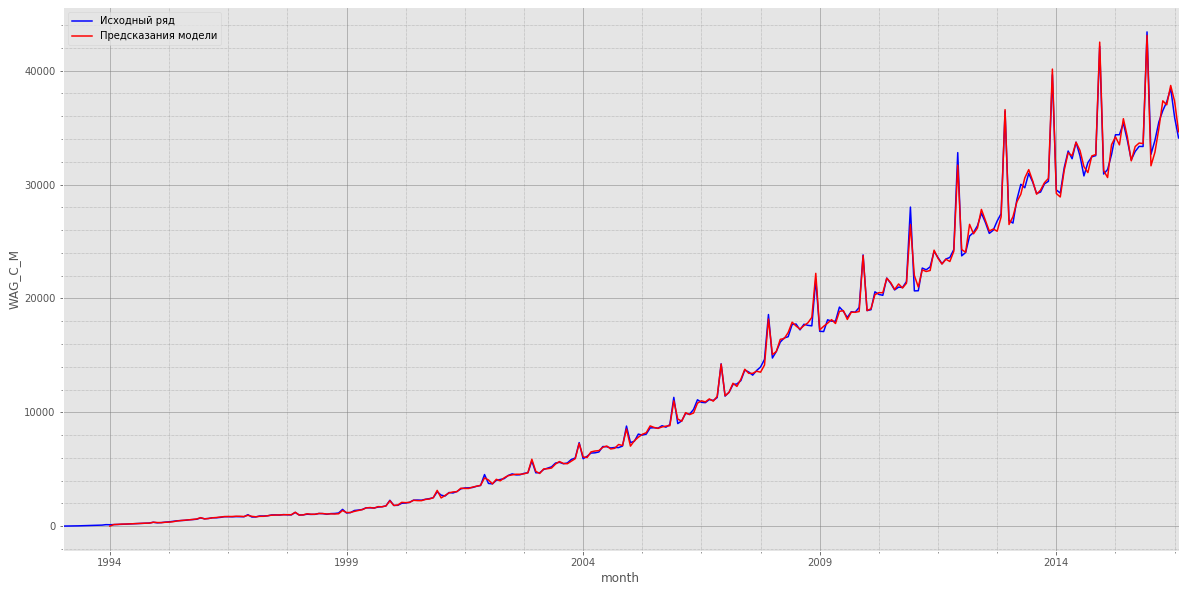

In [28]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

fig, ax = pyplot.subplots(figsize=(20,10))

data['WAG_C_M'].plot(color='b', label='Исходный ряд')
data['model'][12:].plot(color='r', label='Предсказания модели')
pyplot.legend()
pyplot.ylabel('WAG_C_M')
ax.minorticks_on()
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

Видно, модель и данные похожи.

**Прогноз на 45 месяцев (3 года и 9 месяцев) вперед**

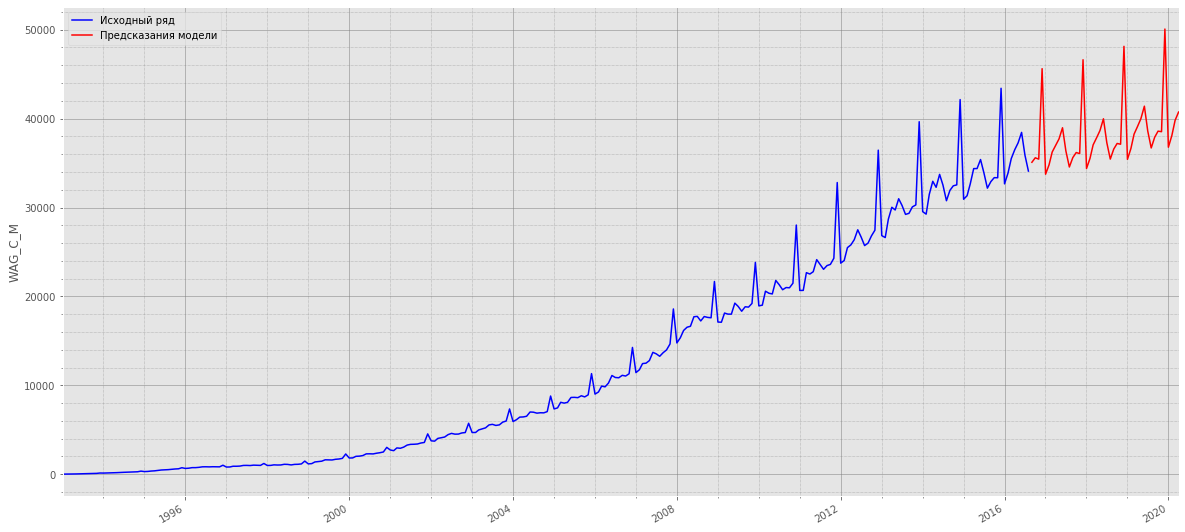

In [29]:
# Период прогноза в месяцах
period = 45 

data2 = data[['WAG_C_M']]
date_list = [datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,period)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
# Обратное преобразование к преобразованию Бокса-Кокса (invboxcox)
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=(data.shape[0]+period-1)), lmbda)

fig, ax = pyplot.subplots(figsize=(20,10))

data2['WAG_C_M'].plot(color='b', label='Исходный ряд')
data2['forecast'].plot(color='r', label='Предсказания модели')

pyplot.legend()
pyplot.ylabel('WAG_C_M')
ax.minorticks_on()
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2000))
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

### 8. Сравнение прогноза

Добавим к полученному прогнозу реальные данные и оценим практическую ценность модели.

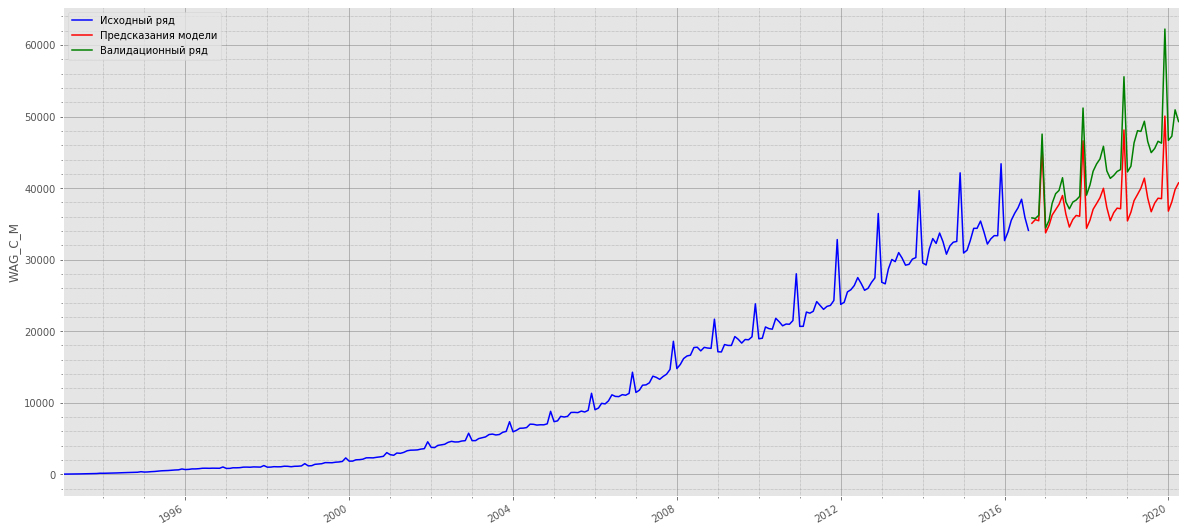

In [30]:
data2['validation'] = new_data[['WAG_C_M']][data.shape[0]:(data.shape[0]+period-1)]

fig, ax = pyplot.subplots(figsize=(20,10))

data2['WAG_C_M'].plot(color='b', label='Исходный ряд')
data2['forecast'].plot(color='r', label='Предсказания модели')
data2['validation'].plot(color='g', label='Валидационный ряд')

pyplot.legend()
pyplot.ylabel('WAG_C_M')
ax.minorticks_on()
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

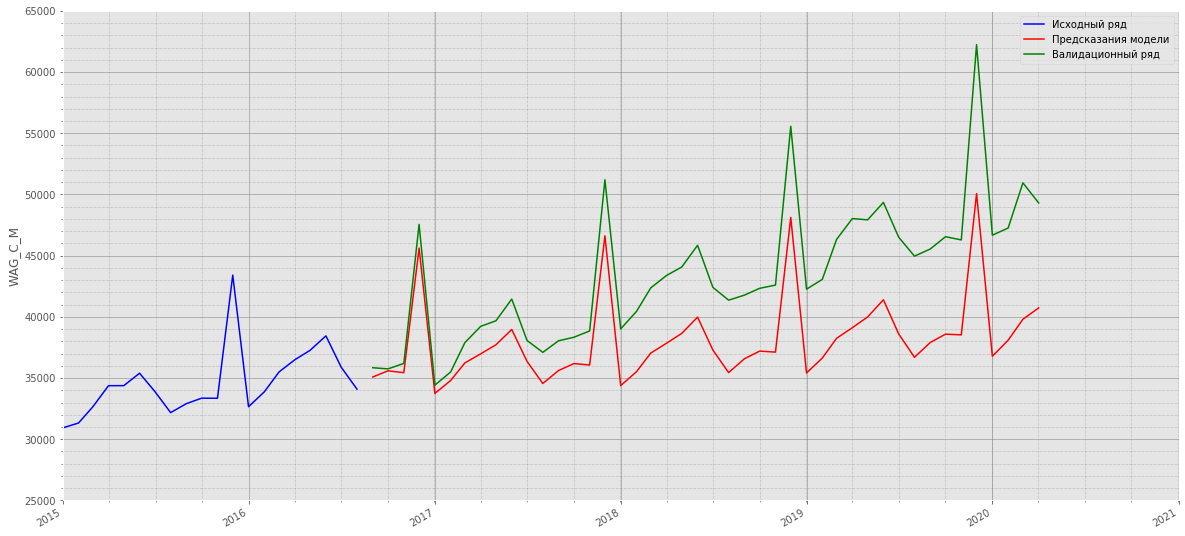

In [31]:
fig, ax = pyplot.subplots(figsize=(20,10))

data2['WAG_C_M'].plot(color='b', label='Исходный ряд')
data2['forecast'].plot(color='r', label='Предсказания модели')
data2['validation'].plot(color='g', label='Валидационный ряд')

pyplot.xlim("2015-01-01", "2021-01-01")
pyplot.ylim(25000, 65000)
pyplot.legend()
pyplot.ylabel('WAG_C_M')
ax.minorticks_on()
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

Посмотрим на остатки (разность прогноза и истиных значений)

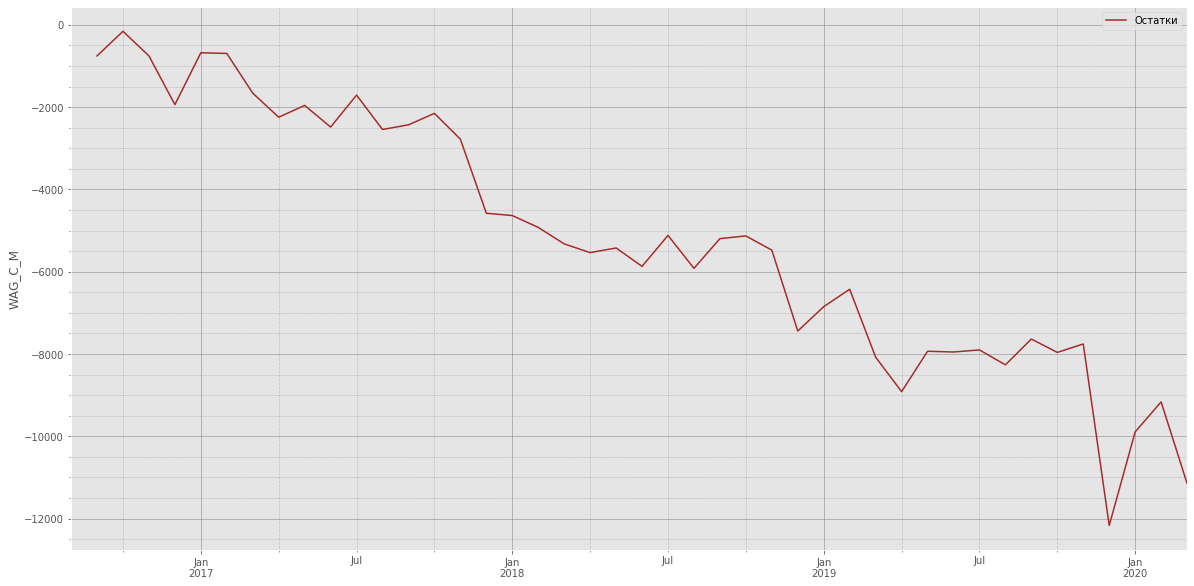

In [32]:
fig, ax = pyplot.subplots(figsize=(20,10))

(data2['forecast'] - data2['validation'])[data.shape[0]:(data.shape[0]+period-1)].plot(color='brown', 
                                                                                       label='Остатки')

pyplot.legend()
pyplot.ylabel('WAG_C_M')
ax.minorticks_on()
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

## Часть 2

### 0. Предобработка данных

В качестве датасета будем использовать данные с сайта Единого архива экономических и социологических данных НИУ ВШЭ

In [33]:
data = new_data[['WAG_C_M']]

### 1. Визуальный анализ ряда

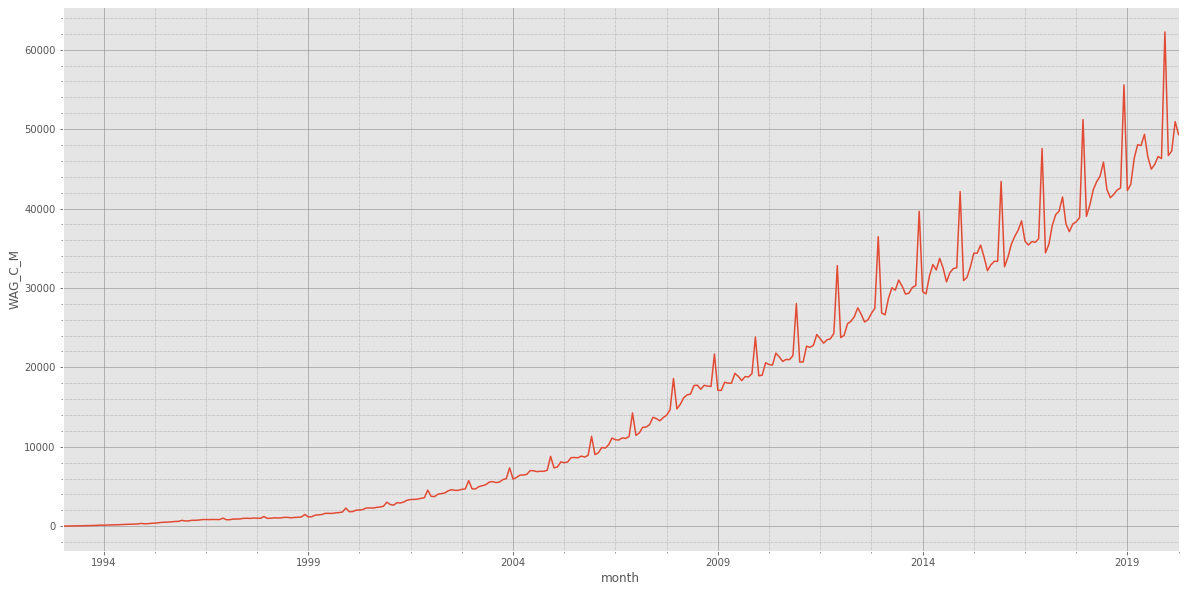

In [34]:
# Прогнозируемый ряд
fig, ax = pyplot.subplots(figsize=(20,10))
data['WAG_C_M'].plot()
pyplot.ylabel('WAG_C_M')
ax.minorticks_on()
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

По графику видно, что ряд обладает слежующими свойствами:
- сильная годовая сезонность: плавный рост зароботной платы в течение года (с января по ноябрь) с резким ростом в декабре и последующим резким падением в январе
- присутствует ярко-выраженный нелинейный тренд (рост заработных плат)
- нестационарна дисперсия (размах сезонных колебаний увеличивается от начала к концу графика).

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.998647


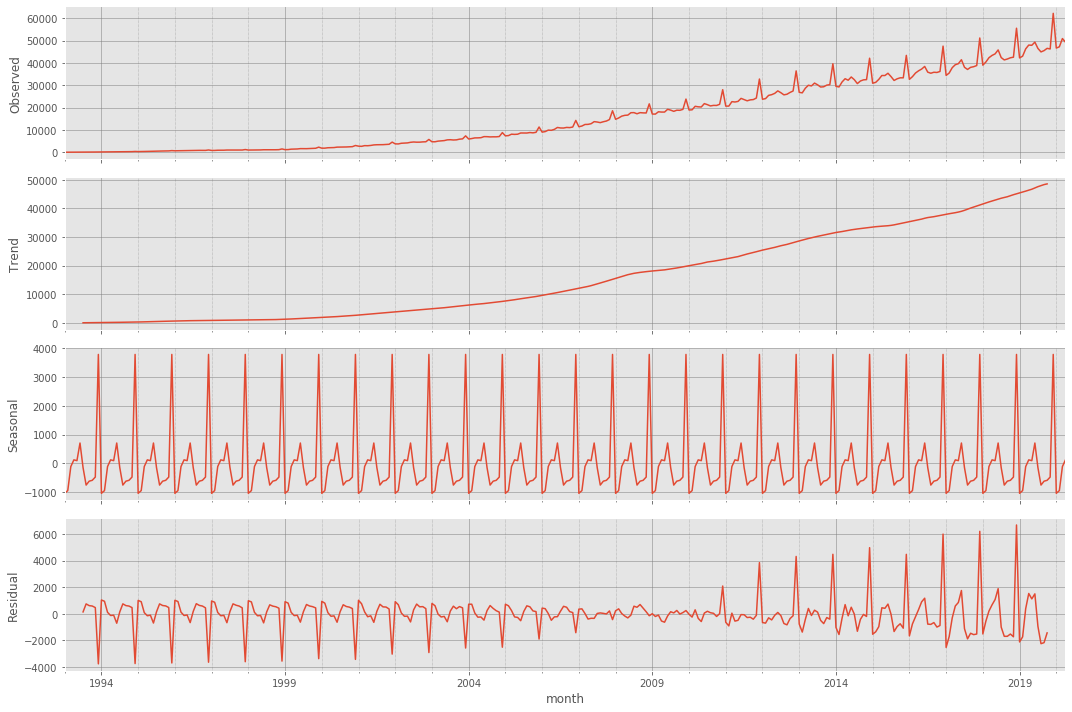

In [35]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M'])[1])

fig, ax = pyplot.subplots(4, 1, figsize=(15,10), sharex=True)
res = sm.tsa.seasonal_decompose(data['WAG_C_M'])
plotseasonal(res, ax, grid=True)
pyplot.tight_layout()
pyplot.show()

Достигаемый уровень значимости критерия Дики-Фуллера > 0.05, т.е. нулевая гипотеза нестационарности для данного ряда не отвергается. __Ряд не стационарен__

По графикам STL-декомпозиции видно:
- сезонный профиль хорошо выражен;
- тренд имеет нелинейную структуру;
- остатки  плавно растут с отрицательных до положительных значений

### 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.290415
Критерий Дики-Фуллера: p=0.529100


C:\Users\Xiaomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


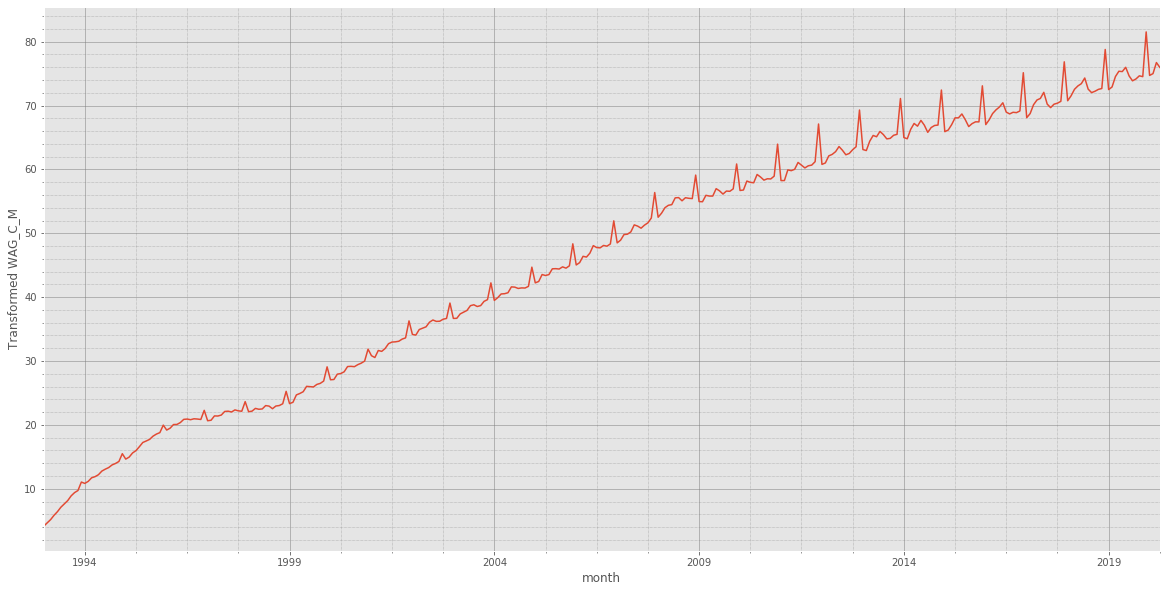

In [36]:
# Функция stats.boxcox возвращает преобразованный ряд и 
# подобранное оптимальное значение lambda

data['WAG_C_M_box'], lmbda = stats.boxcox(data['WAG_C_M'])

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M_box'])[1])

fig, ax = pyplot.subplots(figsize=(20,10))
data['WAG_C_M_box'].plot()
pyplot.ylabel(u'Transformed WAG_C_M')
ax.minorticks_on()
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

Достигаемый уровень значимости критерия Дики-Фуллера > 0.05, т.е. нулевая гипотеза нестационарности для данного ряда не отвергается. __Ряд не стационарен__

В данных по-прежнему:
- сильно выражена сезонность;
- присутствует тренд.

### 3. Выбор порядка дифференцирования

Применим сезонное дифференцирование. Сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность.

Критерий Дики-Фуллера: p=0.189489


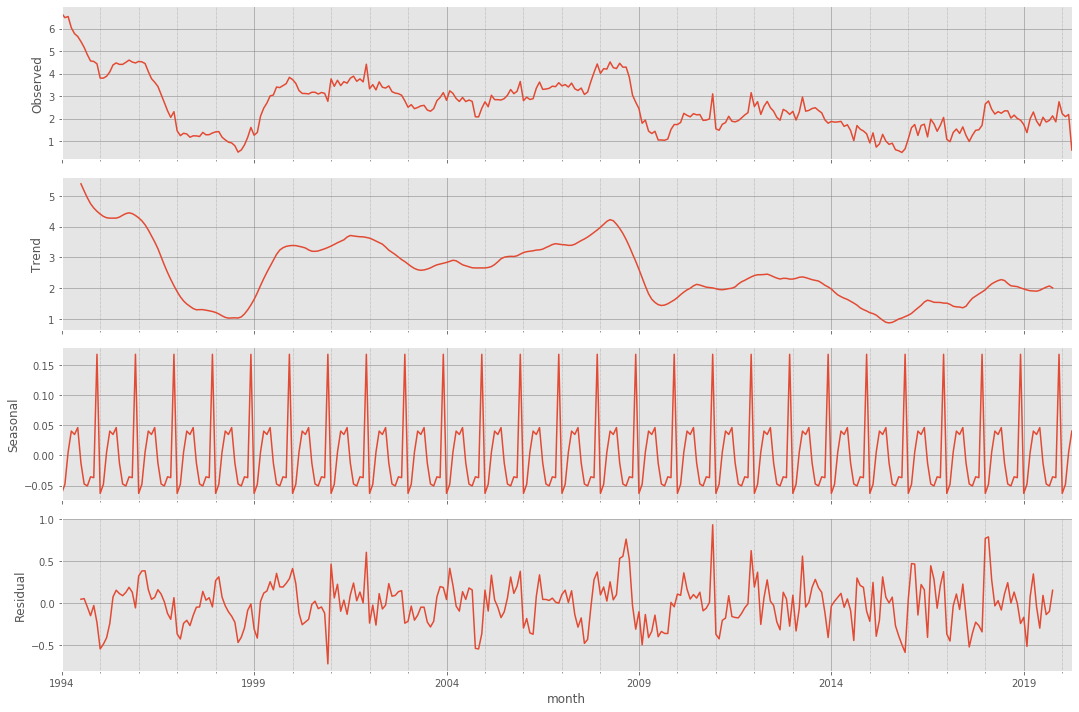

In [37]:
data['WAG_C_M_box_diff'] = data['WAG_C_M_box'] - data['WAG_C_M_box'].shift(12)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M_box_diff'][12:])[1])

fig, ax = pyplot.subplots(4, 1, figsize=(15,10), sharex=True)
res = sm.tsa.seasonal_decompose(data['WAG_C_M_box_diff'][12:])
plotseasonal(res, ax, grid=True)
pyplot.tight_layout()
pyplot.show()

Достигаемый уровень значимости критерия Дики-Фуллера > 0.05, т.е. нулевая гипотеза нестационарности для данного ряда не отвергается. __Ряд не стационарен__

Визуально четкого тренда больше нет.

Добавим ещё обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


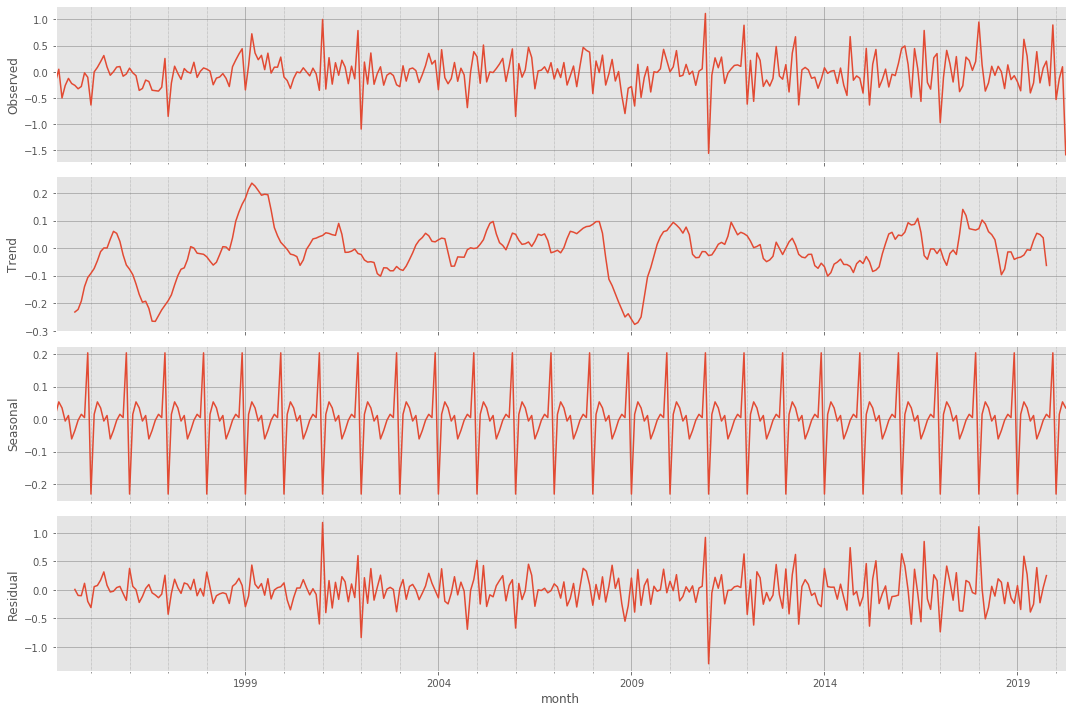

In [38]:
data['WAG_C_M_box_diff2'] = data['WAG_C_M_box_diff'] - data['WAG_C_M_box_diff'].shift(1)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M_box_diff2'][13:])[1])

fig, ax = pyplot.subplots(4, 1, figsize=(15,10), sharex=True)
res = sm.tsa.seasonal_decompose(data['WAG_C_M_box_diff2'][13:])
plotseasonal(res, ax, grid=True)
pyplot.tight_layout()
pyplot.show()

Достигаемый уровень значимости критерия Дики-Фуллера << 0.05, т.е. нулевая гипотеза нестационарности для данного ряда _уверенно_ отвергается. __Ряд стационарен__

Визуально тренд отсутствует. 

### 4. Выбор начальных приближений для $p$, $q$, $P$, $Q$

Построим корреляционную функцию ACF и частично корреляционную функцию PACF полученного ряда

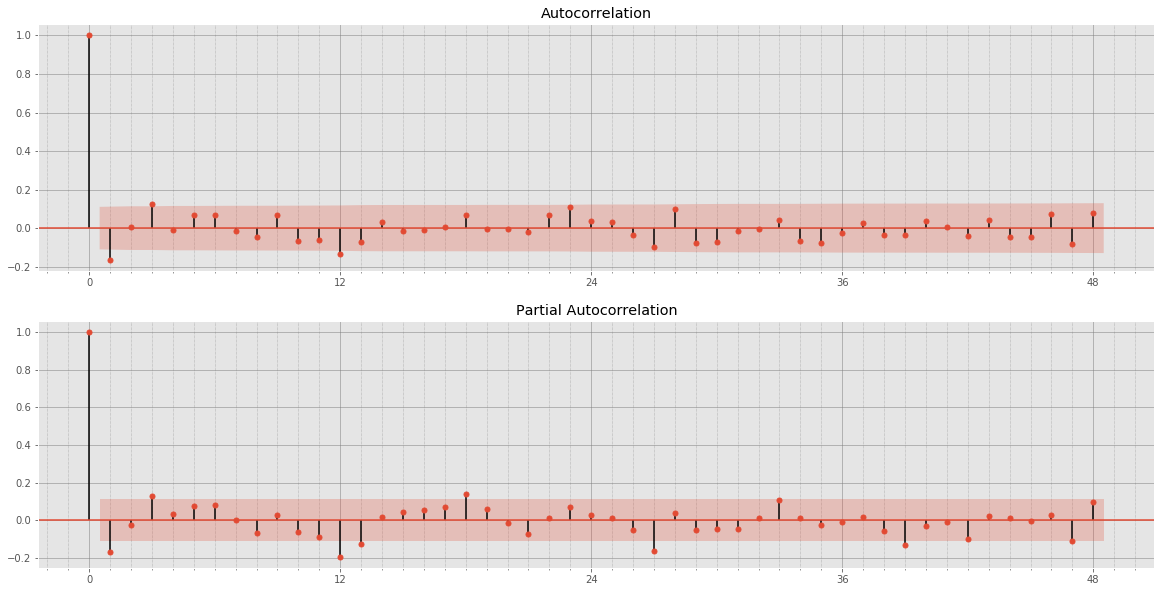

In [39]:
fig, ax = pyplot.subplots(2, 1, figsize=(20,10))

ax = pyplot.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(data['WAG_C_M_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle = ':')

ax = pyplot.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(data['WAG_C_M_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle = ':')

pyplot.show()

Из графика автокорреляции: 
- Максимальный сезонный лаг, значимо отличающийся от нуля равен 12, следовательно начальное приближение $Q=1$. 
- Максимальный несезонный лаг в первом сезоне равен 3, следовательно начальное приближение $q=3$.

Из графика частичной автокорреляции:
- Максимальный сезонный лаг, значимо отличающийся от нуля равен 12, следовательно начальное приближение $P=1$.
- Максимальный несезонный лаг в первом сезоне равен 3, следовательно начальное приближение $p=3$.

### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

Перебором подберем оптимальные параметры модели ARIMA. Перебор осуществляется по всем значениям от нуля до максимального, равного начальному приближению.

In [40]:
ps = range(0, 4)
d=1
qs = range(0, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [41]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

64


Всего необходимо перебрать 64 модели.

Для каждой модели посчитаем значение информационного критерия Акаике.

Выберем модель с минимальным значением этого критерия.

In [42]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['WAG_C_M_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        # Выводит модели, на которых сходимости не произошло
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 57.8 s


In [43]:
# Лучшие модели
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
45  (2, 3, 0, 1)  170.707178
42  (2, 2, 1, 0)  174.769930
43  (2, 2, 1, 1)  174.988441
41  (2, 2, 0, 1)  175.875157
61  (3, 3, 0, 1)  178.194868


### 6. Анализ остатков построенной модели, её модификация

In [44]:
# Лучшая модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  328
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 12)   Log Likelihood                 -78.354
Date:                            Mon, 13 Jul 2020   AIC                            170.707
Time:                                    14:00:36   BIC                            196.975
Sample:                                01-01-1993   HQIC                           181.202
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7510      0.073     24.065      0.000       1.608       1.894
ar.L2         -0.8696      0.066   

Достигаемый уровень значимости критерия Льюнг — Бокса при некотором автоматически выбранном $Q$ > 0.05.

То есть, по всей видимости, остатки модели не автокоррелированы.

Критерий Стьюдента: p=0.228820
Критерий Дики-Фуллера: p=0.000000


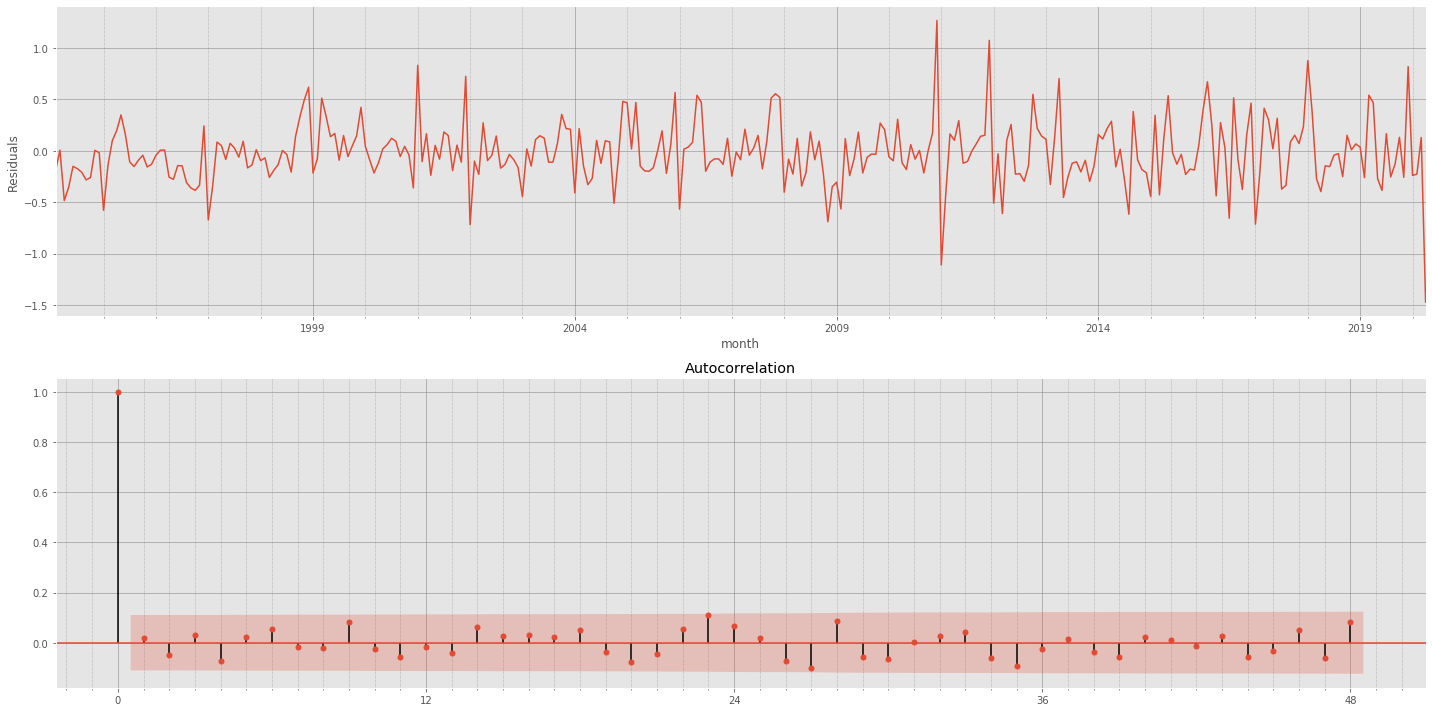

In [45]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

fig, ax = pyplot.subplots(2, 1, figsize=(20,10))

ax = pyplot.subplot(2, 1, 1)
best_model.resid[13:].plot()
pyplot.ylabel(u'Residuals')
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')

ax = pyplot.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle = ':')

pyplot.tight_layout()
pyplot.show()

В остатках не видно никакого тренда, никакой сезонности, они похожи на шум. 

На графике автокорреляционной функции этих остатков нет существенной структуры.

Проверим свойства остатков с помощью формальных критериев. 
- __Критерий Стьюдента__ проверяет __гипотезу несмещённости__ и её не отвергает с достигаемым уровнем значимости примерно 0,23. __Остатки несмещены__.
- __Критерий Дики-Фуллера__ уверенно отвергает __гипотезу нестационарности__. __Остатки стационарны__.
- __Критерий Льюнга-Бокса__ и __коррелограмма__ отвергают гипотезу автокоррелированности. __Остатки неавтокоррелированы__.

__Следовательно, модель достаточно хороша__.

### 7. Прогнозирование с помощью финальной модели

Посмотрим, насколько хорошо модель описывает данные

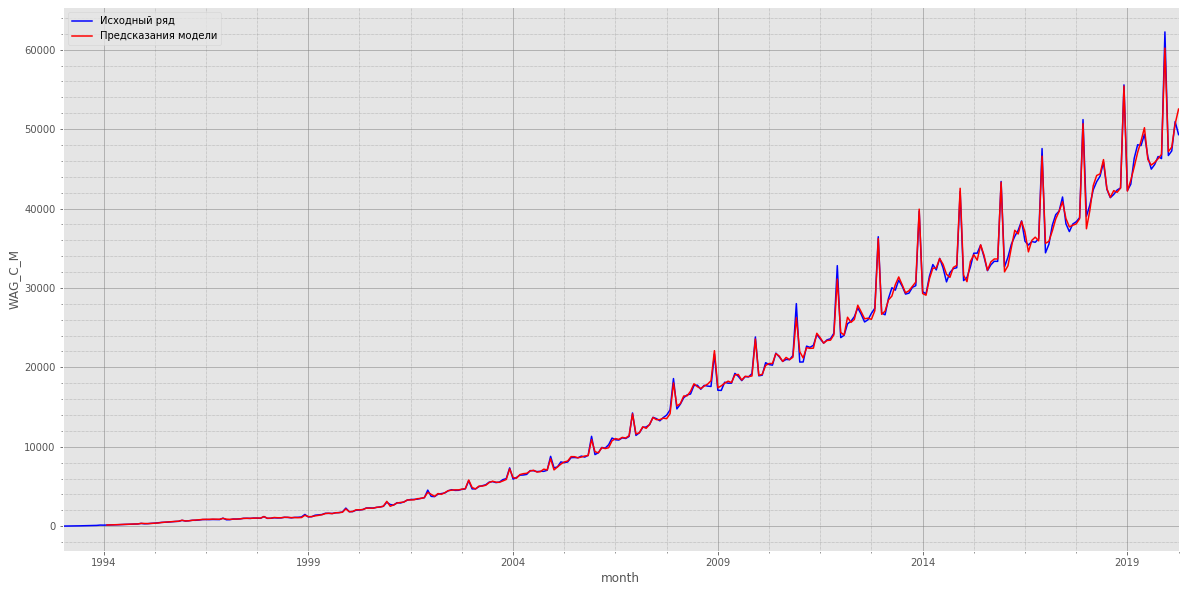

In [46]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

fig, ax = pyplot.subplots(figsize=(20,10))

data['WAG_C_M'].plot(color='b', label='Исходный ряд')
data['model'][13:].plot(color='r', label='Предсказания модели')

pyplot.legend()
pyplot.ylabel('WAG_C_M')
ax.minorticks_on()
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()

Видно, модель и данные похожи.

**Прогноз на 2 года вперед**

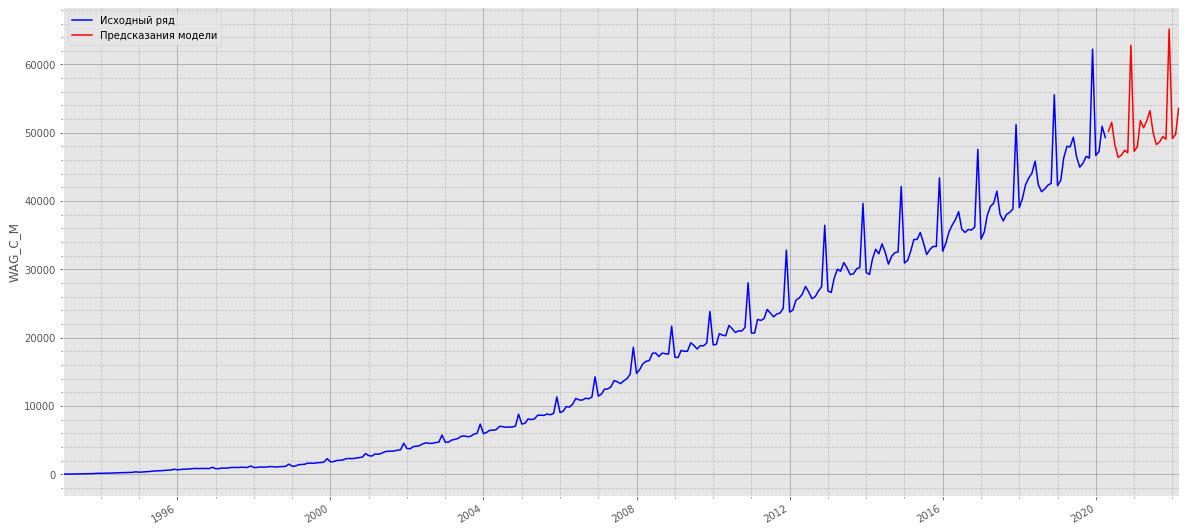

In [61]:
# Период прогноза в месяцах
period = 24 

data2 = data[['WAG_C_M']]
date_list = [datetime.strptime("2020-04-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,period)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
# Обратное преобразование к преобразованию Бокса-Кокса (invboxcox)
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=(data.shape[0]+period-1)), lmbda)

fig, ax = pyplot.subplots(figsize=(20,10))

data2['WAG_C_M'].plot(color='b', label='Исходный ряд')
data2['forecast'].plot(color='r', label='Предсказания модели')

pyplot.legend()
pyplot.ylabel('WAG_C_M')
ax.minorticks_on()
ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')
pyplot.show()